In [1]:
import os
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join("..")))
from src.data_loader import get_cleaned_data
from src.feature_engineering import feature_engineering
sns.set_theme(style="whitegrid")

In [ ]:
# clean_data_path = "../data/cleaned/cleaned_data.npz"
# data = np.load(clean_data_path, allow_pickle=True)
# X = data["X"] # data
# y = data["y"] # target values
# features = data["features"].tolist() # features
# time = data["time"] # time index

In [2]:
df = get_cleaned_data()
X, y, features, time = feature_engineering(df)

In [3]:
print("Data head:\n", X[:5, :])
print("Target head:\n", y[:5])
print("Features:\n", features)
print("Time Index Head:\n", time[:5])

Data head:
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.33883739e-01
  -9.00968868e-01  5.00000000e-01  8.66025404e-01  5.04180000e+04
   4.11330000e+04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.67760000e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.33883739e-01
  -9.00968868e-01  5.00000000e-01  8.66025404

In [4]:
def MAE(y_true, y_pred):
    return np.abs(y_pred - y_true).mean()

def RMSE(y_true, y_pred):
    return np.sqrt(((y_pred - y_true)**2).mean())

def MAPE(y_true, y_pred):
    return (np.abs(y_pred - y_true) / y_true * 100).mean()

## Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [6]:
# Cross-validation

tscv = TimeSeriesSplit(n_splits=5)
mae_scores, rmse_scores, mape_scores = [], [], []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = MAE(y_test, y_pred)
    rmse = RMSE(y_test, y_pred)
    mape = MAPE(y_test, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

print(f"Avg MAE: {np.mean(mae_scores):.2f} MW")
print(f"Avg RMSE: {np.mean(rmse_scores):.2f} MW")
print(f"Avg MAPE: {np.mean(mape_scores):.2f} %")

Avg MAE: 875.48 MW
Avg RMSE: 1243.21 MW
Avg MAPE: 1.64 %


In [7]:
split_idx = int(0.8 * X.shape[0])
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae = MAE(y_test, y_pred)
rmse = RMSE(y_test, y_pred)
mape = MAPE(y_test, y_pred)

print(f"Linear Regression MAE:  {mae:.2f} MW")
print(f"Linear Regression RMSE: {rmse:.2f} MW")
print(f"Linear Regression MAPE: {mape:.2f} %")

Linear Regression MAE:  857.57 MW
Linear Regression RMSE: 1217.77 MW
Linear Regression MAPE: 1.61 %


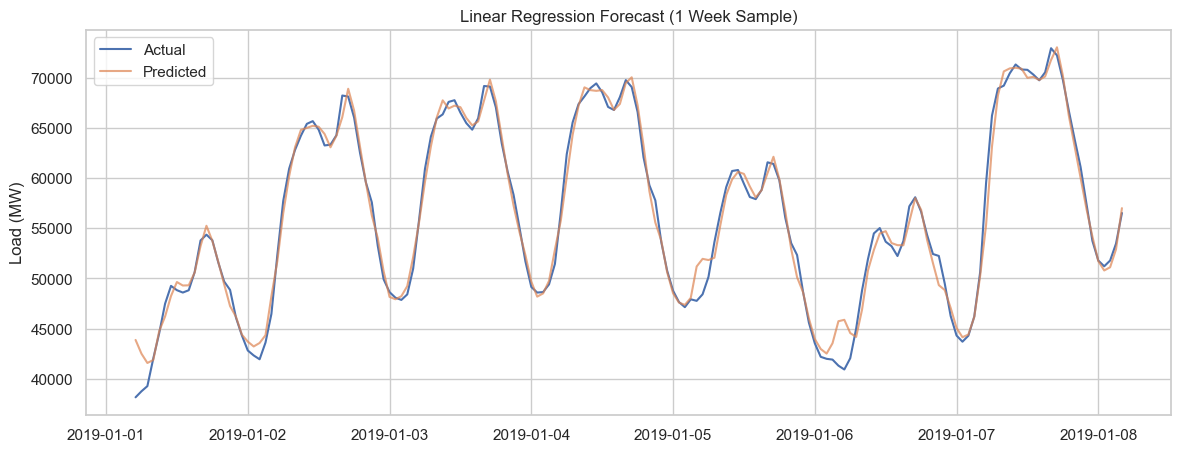

In [9]:
# Plot actual load versus predicted load for 1 week

plt.figure(figsize=(14, 5))
plt.plot(time[split_idx:split_idx+168], y_test[:168], label="Actual")
plt.plot(time[split_idx:split_idx+168], y_pred[:168], label="Predicted", alpha=0.7)
plt.title("Linear Regression Forecast (1 Week Sample)")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

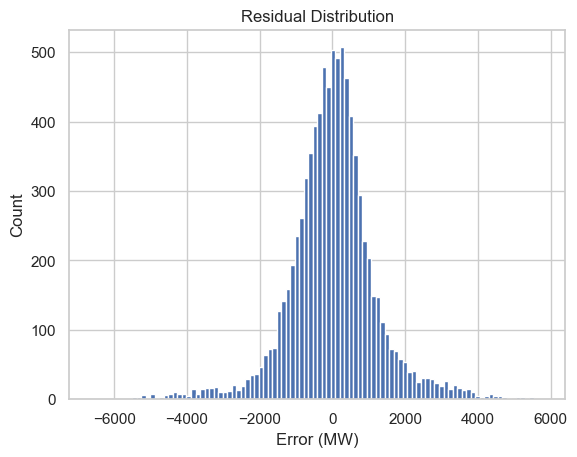

In [10]:
# plot residuals for our model
residuals = y_test - y_pred
plt.hist(residuals, bins=100)
plt.title("Residual Distribution")
plt.xlabel("Error (MW)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

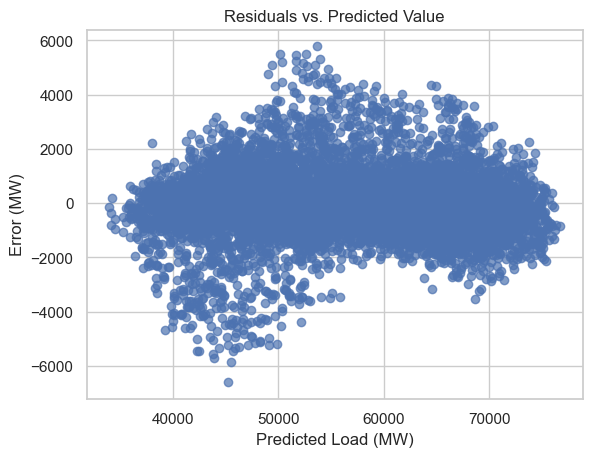

In [14]:
# check homoscedasticity
plt.scatter(y_pred, residuals, alpha=0.7)
plt.title("Residuals vs. Predicted Value")
plt.xlabel("Predicted Load (MW)")
plt.ylabel("Error (MW)")
plt.grid(True)
plt.show()

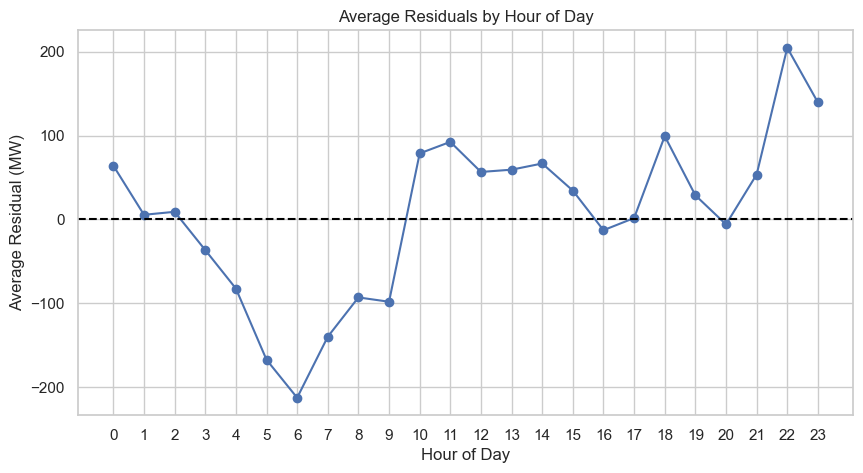

In [ ]:
# check residuals over time
# residuals and hour

# hour_index = features.index("hour_sin")

res_hour = pd.DataFrame({
    "residuals": residuals,
    "hour": pd.to_datetime(time[split_idx:]).hour
}) 

hourly_mean_error = res_hour.groupby("hour")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(hourly_mean_error.index, hourly_mean_error.values, marker='o')
plt.title("Average Residuals by Hour of month")
plt.xlabel("Hour of month")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.axhline(0, color='black', linestyle='--')
plt.show()

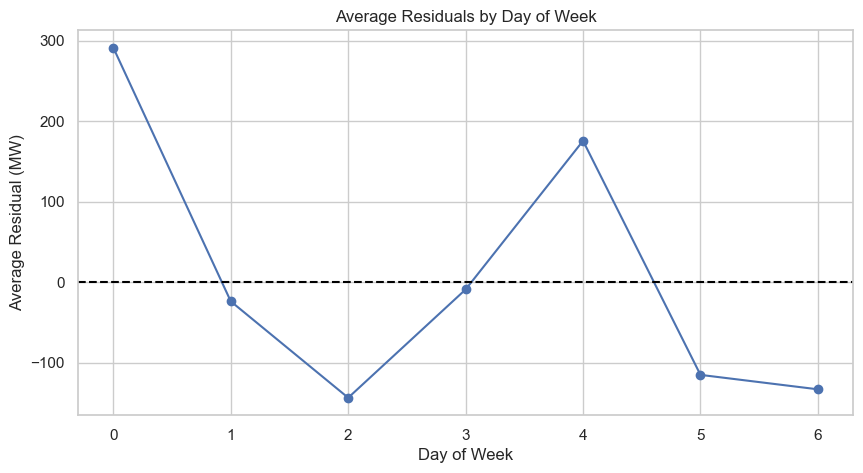

In [17]:
res_day = pd.DataFrame({
    "residuals": residuals,
    "day": pd.to_datetime(time[split_idx:]).day_of_week
}) 

daily_mean_error = res_day.groupby("day")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(daily_mean_error.index, daily_mean_error.values, marker='o')
plt.title("Average Residuals by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 7))
plt.axhline(0, color='black', linestyle='--')
plt.show()

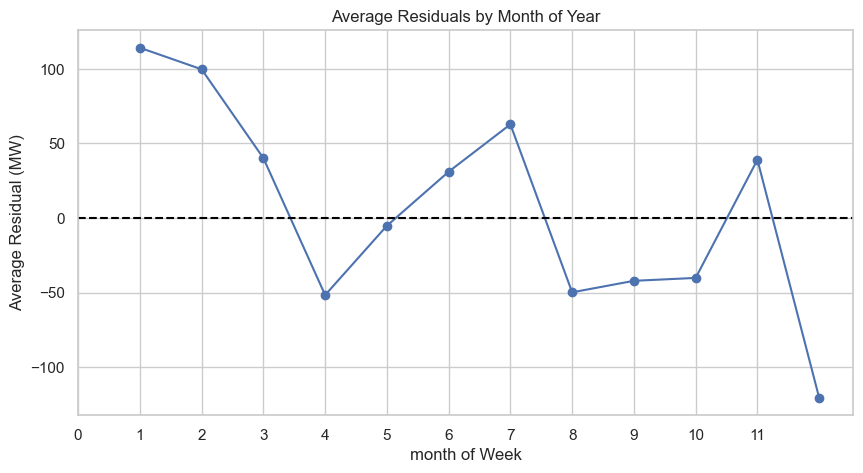

In [19]:
res_month = pd.DataFrame({
    "residuals": residuals,
    "month": pd.to_datetime(time[split_idx:]).month
}) 

monthly_mean_error = res_month.groupby("month")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_mean_error.index, monthly_mean_error.values, marker='o')
plt.title("Average Residuals by Month of Year")
plt.xlabel("month of Week")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 12))
plt.axhline(0, color='black', linestyle='--')
plt.show()